In [1]:
#!pip install numpy==1.23.5
#!pip install pandas==1.5.3

In [2]:
# plot data processing statistics
plot_data_process = True

# choose the Hyper-Parameters
# data Hyper-Parameters
num_features = 34 # maximum 34
scaler_name = 'minmax' # choose from ['standard','minmax']
train_batch_size = 32
eval_batch_size = 32
epochs = 50
bptt_src = 10
bptt_tgt = 2
overlap = 1

# model Hyper-Parameters
num_encoder_layers = 4
num_decoder_layers = 4
periodic_features = 10
out_features = 60 # must be greater or equal to (num_features + periodic_features)
nhead = 15 # must divide out_features
dim_feedforward = 384
dropout = 0.0
activation = 'gelu' # choose from ['relu','gelu']

# training Hyper-Parameters
random_start_point = False
clip_param = 0.75
lr = 0.5
gamma = 0.95
step_size = 1.0

In [3]:
#installations
!pip install finta
!pip install torch-summary

In [4]:
# packages import
# Numpy
import numpy as np

# Pandas
import pandas as pd 

# Pytorch
import torch
import torch.nn as nn
from torch import Tensor
from torchsummary import summary

# Seaborn
import seaborn as sns

# Finta
from finta import TA

# Others
import matplotlib.pyplot as plt
import time
import os
import math
import copy
import sklearn.preprocessing as pp

In [5]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
# font configuration
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [7]:
# load the data
data = pd.read_csv("../input/btcusdt/okex_btcusdt_kline_1m.csv")
columns_dict = {'t': 'Unix_timestamp',
                'o': 'Opening_price',
                'h': 'Highest_price',
                'l': 'Lowest_price',
                'c': 'Closing_price',
                'v': 'Volume_of_transactions'
               }
data = data.rename(columns=columns_dict)

In [8]:
# show info of data
if plot_data_process:
    data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488160 entries, 0 to 488159
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Unix_timestamp          488160 non-null  int64  
 1   Opening_price           488160 non-null  float64
 2   Highest_price           488160 non-null  float64
 3   Lowest_price            488160 non-null  float64
 4   Closing_price           488160 non-null  float64
 5   Volume_of_transactions  488160 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 22.3 MB


In [9]:
# print first 5 lines of data
if plot_data_process:
    data.head()

In [10]:
# sort datapoints by timestamp
data = data.sort_values('Unix_timestamp', ignore_index=True)

In [11]:
# converts format from unix to UTC+8
data['Unix_timestamp'] = pd.to_datetime(data['Unix_timestamp'], unit='ms') + pd.Timedelta('08:00:00')
data = data.rename(columns={'Unix_timestamp': 'Timestamp'})

In [12]:
# print first 5 lines of data
if plot_data_process:
    data.head()

In [13]:
# print last 5 lines of data
if plot_data_process:
    data.tail()

In [14]:
def plot_correlation(data, title, figsize=(10, 5)):
    """Plots correlations between all columns in data

    Args:
        data: DataFrame, holds the data
        title: string, desired title of the plot
        figsize: tuple, width and height of the figure in inches
    """
    f,ax = plt.subplots(figsize=figsize)
    sns.heatmap(data.corr()*100, annot=True, linewidths=5, fmt= '.2f',ax=ax)
    plt.title(title)
    plt.xticks(rotation= 60) 
    plt.show()

In [15]:
def plot_scaled_features(data, features_to_plot, scaler=None, xlabel="Time"):
    """Plots desired features in data after scaling

    Args:
        data: DataFrame, holds the data
        xlabel: string, desired x label of the plot
        scaler: function, scaling function
        features_to_plot: list of strings, columns names of data to plot
    """
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1, 1 ,1)
    ax.set_xlabel(xlabel)     
    ax.set_ylabel("Features' Values [a.u]")            
    ax.set_title("Features' Values Through Time")   
    ax.grid()
    for column in data:
        if column not in features_to_plot:
            continue
        feature = data[column].values
        if scaler is not None:
            feature_normalized = scaler.fit_transform(feature.reshape(-1,1))
        else:
            feature_normalized = feature
        ax.plot(feature_normalized, label=column)
    ax.legend()    
    plt.show()

C:\Users\23695\AppData\Local\Temp\ipykernel_57876\424269441.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr()*100, annot=True, linewidths=5, fmt= '.2f',ax=ax)
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: F

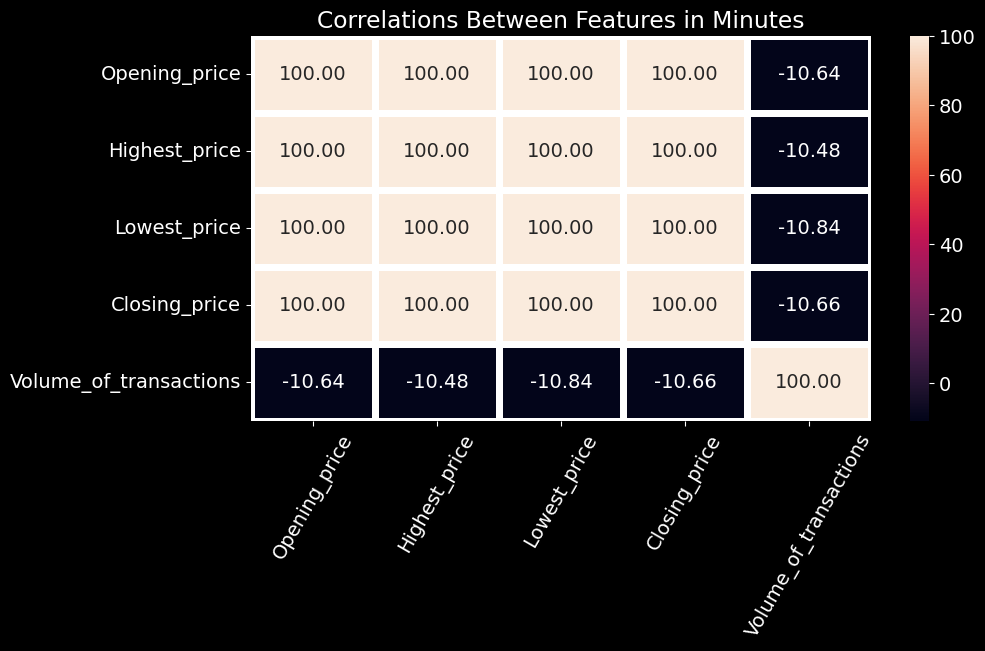

In [16]:
# check correlation between features in minutes form
if plot_data_process:
    plot_correlation(data, 
                     title="Correlations Between Features in Minutes")

In [17]:
# add finta features
def add_finta_feature(data, data_finta ,feature_names, both_columns_features):
    """Adds new fanta features to data by their feature_name in feature_names

    Args:
        data: DataFrame, where the feature will be added
        data_finta: DataFrame, columns' names are: 'open', 'high', 'low', 'close' and 'volume'(optinal)
                    from which the new feature will be calculated
        feature_names: list of strings, names of the new features you want to add
        both_columns_features: list of strings, names of the new features you want to add both of their outputs
    """
    for feature_name in feature_names:
        feature_func = getattr(TA, feature_name)
        finta_feature = feature_func(data_finta) 
        if finta_feature.ndim > 1:
            if feature_name in both_columns_features:
                data["{}_1".format(feature_name)] = finta_feature.iloc[:, 0]
                data["{}_2".format(feature_name)] = finta_feature.iloc[:, 1]
            else:
                data[feature_name] = finta_feature.iloc[:, 0]
        else:
            data[feature_name] = finta_feature
        
# Finta needs specific columns' names to work
data_finta = pd.DataFrame()
data_finta['open'] = data['Opening_price']
data_finta['high'] = data['Highest_price']
data_finta['low'] = data['Lowest_price']
data_finta['close'] = data['Closing_price']
data_finta['volume'] = data['Volume_of_transactions']

# create data with all wanted features per minute
data_min = data.copy()
extra_features = ['TRIX', 'VWAP', 'MACD', 'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI', 'ADX', 'STOCHRSI',
                  'MI', 'CHAIKIN', 'VZO', 'PZO', 'EFI', 'EBBP', 'BASP', 'BASPN', 'WTO', 'SQZMI', 'VFI', 'STC']
both_columns_features = ["DMI", "EBBP", "BASP", "BASPN"]
add_finta_feature(data_min, data_finta, extra_features, both_columns_features)

c:\Users\23695\PycharmProjects\-Bitcoin-Price-Prediction-Using-Transformers\.venv\Lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):
c:\Users\23695\PycharmProjects\-Bitcoin-Price-Prediction-Using-Transformers\.venv\Lib\site-packages\finta\finta.py:399: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x, y in zip(x.fillna(0).iteritems(), y.iteritems()):


C:\Users\23695\AppData\Local\Temp\ipykernel_57876\424269441.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr()*100, annot=True, linewidths=5, fmt= '.2f',ax=ax)
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: F

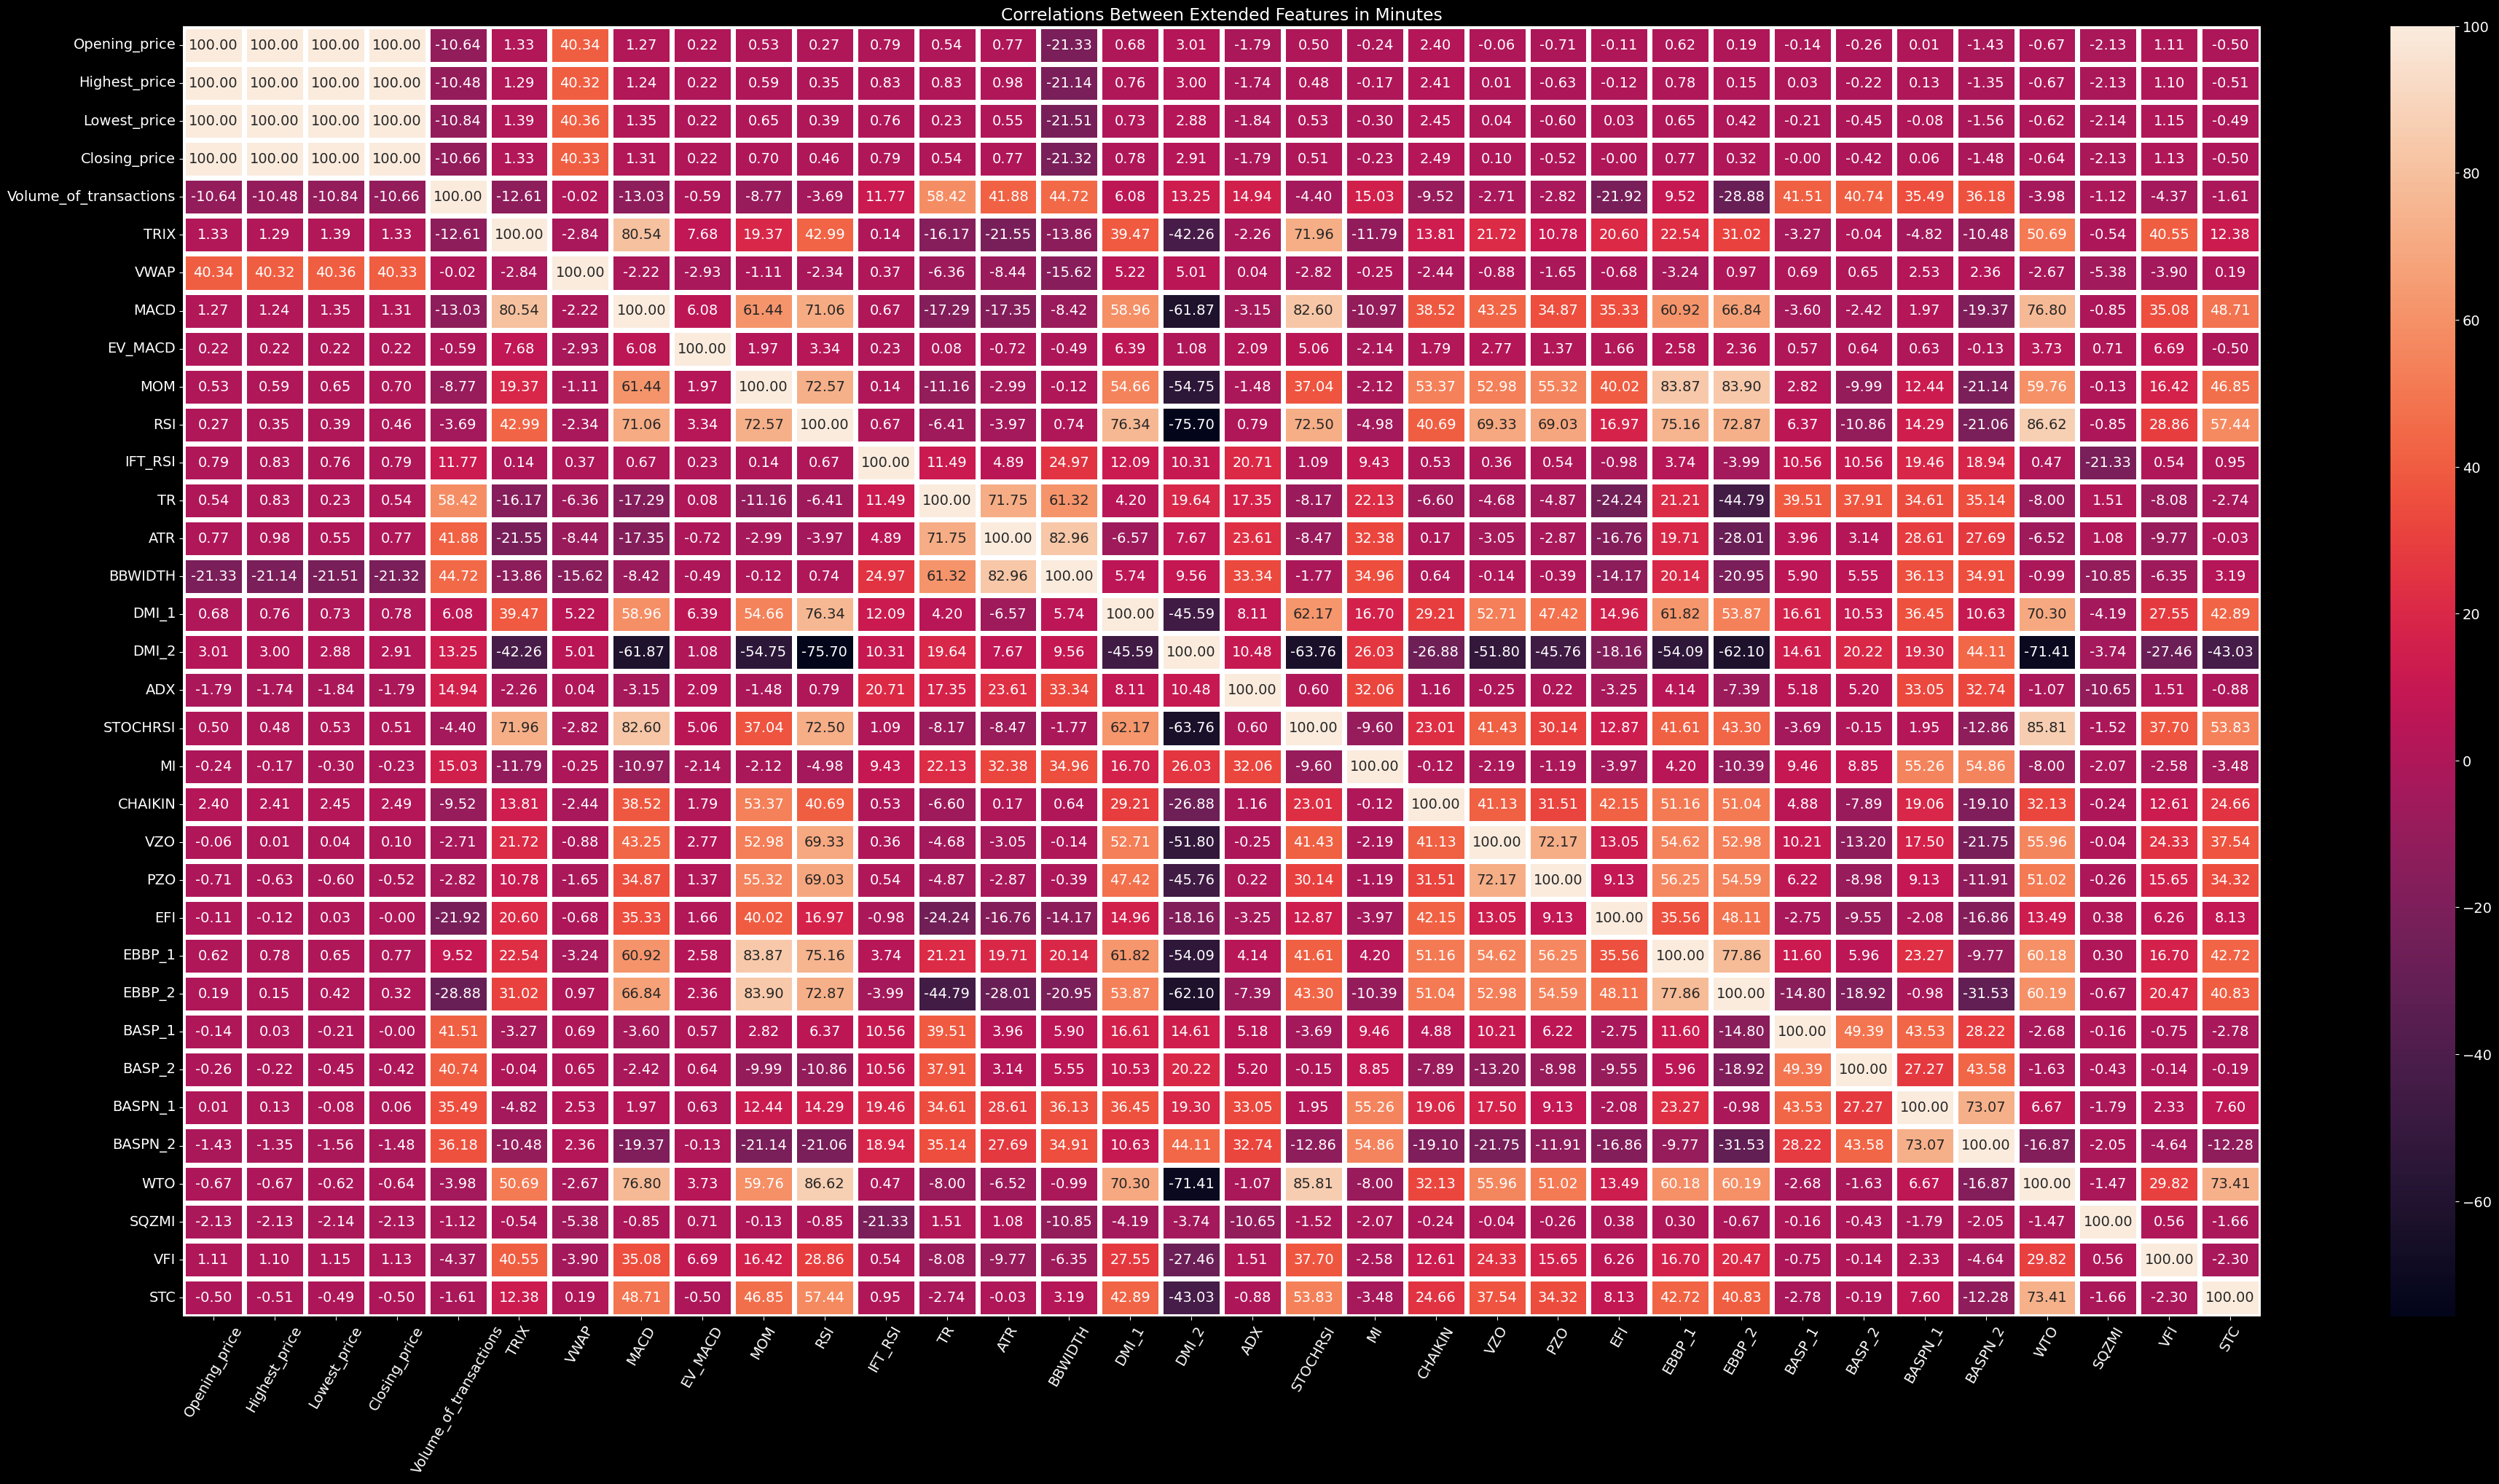

In [18]:
# check correlation between all features including new ones in minutes form
if plot_data_process:
    plot_correlation(data_min,
                     title="Correlations Between Extended Features in Minutes",
                     figsize=(46, 23))

In [19]:
# show info of data
if plot_data_process:
    data_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488160 entries, 0 to 488159
Data columns (total 35 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Timestamp               488160 non-null  datetime64[ns]
 1   Opening_price           488160 non-null  float64       
 2   Highest_price           488160 non-null  float64       
 3   Lowest_price            488160 non-null  float64       
 4   Closing_price           488160 non-null  float64       
 5   Volume_of_transactions  488160 non-null  float64       
 6   TRIX                    488159 non-null  float64       
 7   VWAP                    488160 non-null  float64       
 8   MACD                    488160 non-null  float64       
 9   EV_MACD                 488160 non-null  float64       
 10  MOM                     488150 non-null  float64       
 11  RSI                     488159 non-null  float64       
 12  IFT_RSI                 488151

In [20]:
# find the maximum index containing NaN
if plot_data_process:
    print("Last index containing NaN in each feature:")
max_index = -np.inf
for column in data_min.columns:
    nan_indices = data_min[column].index[data_min[column].apply(np.isnan)]
    max_index_column = np.max(nan_indices)
    if plot_data_process:
        print("\t", column, ":", max_index_column)
    if max_index_column > max_index:
        max_index = max_index_column
if plot_data_process:
    print("\nLast index containing NaN in all data:", max_index)

Last index containing NaN in each feature:
	 Timestamp : nan
	 Opening_price : nan
	 Highest_price : nan
	 Lowest_price : nan
	 Closing_price : nan
	 Volume_of_transactions : nan
	 TRIX : 0
	 VWAP : nan
	 MACD : nan
	 EV_MACD : nan
	 MOM : 9
	 RSI : 0
	 IFT_RSI : 8
	 TR : nan
	 ATR : 12
	 BBWIDTH : 18
	 DMI_1 : 12
	 DMI_2 : 12
	 ADX : 12
	 STOCHRSI : 13
	 MI : 23
	 CHAIKIN : 7
	 VZO : nan
	 PZO : nan
	 EFI : 0
	 EBBP_1 : nan
	 EBBP_2 : nan
	 BASP_1 : nan
	 BASP_2 : nan
	 BASPN_1 : nan
	 BASPN_2 : nan
	 WTO : 0
	 SQZMI : nan
	 VFI : 130
	 STC : 12

Last index containing NaN in all data: 130


In [21]:
# drop the rows up to the last Nans in data of minutes - 131 minutes
start_index = max_index + 1
data_min = data_min.iloc[start_index: , :]
data_min = data_min.reset_index(drop=True)
start_hour = start_index // 60
start_minute = start_index % 60
# Drop Non-numeric columns
data_min.drop(['Timestamp'], inplace=True, axis=1)

# reorder columns by importance:
new_columns_order = ['Closing_price', 'Volume_of_transactions', 'Opening_price', 'Highest_price', 'Lowest_price','TRIX', 'VWAP', 'MACD',
                     'EV_MACD', 'MOM', 'RSI', 'IFT_RSI', 'TR', 'ATR', 'BBWIDTH', 'DMI_1', 'DMI_2', 'ADX', 'STOCHRSI', 'MI', 'CHAIKIN', 
                     'VZO', 'PZO', 'EFI', 'EBBP_1', 'EBBP_2', 'BASP_1', 'BASP_2', 'BASPN_1', 'BASPN_2', 'WTO', 'SQZMI', 'VFI', 'STC']
data_min = data_min[new_columns_order]
# show info of data - now there are no Nans
if plot_data_process:
    data_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488029 entries, 0 to 488028
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Closing_price           488029 non-null  float64
 1   Volume_of_transactions  488029 non-null  float64
 2   Opening_price           488029 non-null  float64
 3   Highest_price           488029 non-null  float64
 4   Lowest_price            488029 non-null  float64
 5   TRIX                    488029 non-null  float64
 6   VWAP                    488029 non-null  float64
 7   MACD                    488029 non-null  float64
 8   EV_MACD                 488029 non-null  float64
 9   MOM                     488029 non-null  float64
 10  RSI                     488029 non-null  float64
 11  IFT_RSI                 488029 non-null  float64
 12  TR                      488029 non-null  float64
 13  ATR                     488029 non-null  float64
 14  BBWIDTH             

In [22]:
# show all features
pd.options.display.max_columns = data_min.shape[1]
# print first 5 lines of data
if plot_data_process:
    data_min.head()

In [23]:
# print last 5 lines of data
if plot_data_process:
    data_min.tail()

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

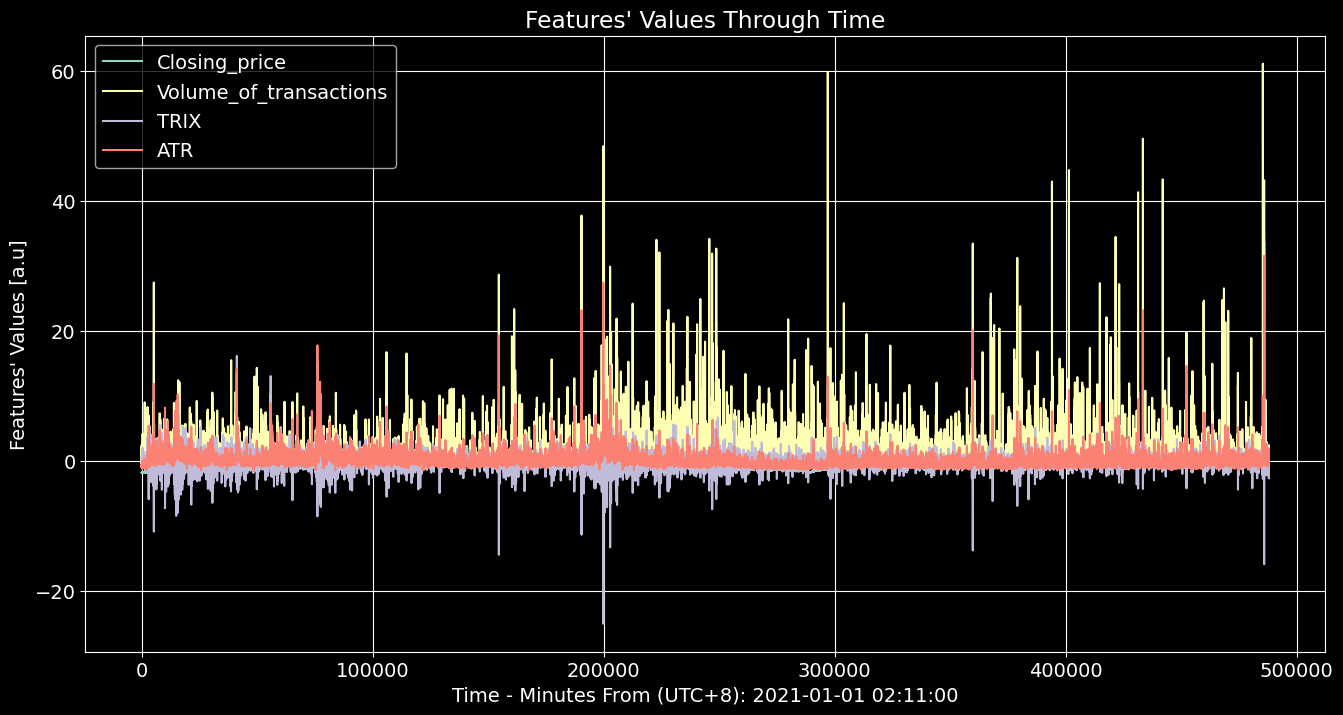

In [24]:
# plot chosen features per minute
if plot_data_process:
    plot_scaled_features(data_min, 
                         features_to_plot=['Closing_price', 'Volume_of_transactions', 'TRIX', 'ATR'],
                         scaler=pp.StandardScaler(),
                         xlabel="Time - Minutes From (UTC+8): 2021-01-01 {:02d}:{:02d}:00".format(start_hour, start_minute)
                        )

In [25]:
# split the data to train, validation and test
def train_validation_test_split(data, val_percentage, test_percentage):
    """Splits the data into train, validation and test

    Args:
        data: Tensor, shape [N, E]
        val_percentage: float, validation percentage from the data [0,1]
        test_percentage: float, test percentage from the data (0,1]
    Returns:
        train: Tensor, shape [N - N * (val_percentage + test_percentage), E]
        val: Tensor, shape [N * val_percentage, E] or None if val_percentage = 0
        test: Tensor, shape [N * test_percentage, E]
    """
    data_length = len(data)
    
    val_length = int(data_length * val_percentage)
    test_length = int(data_length * test_percentage)
    train_length = data_length - val_length - test_length
    
    train = data[:train_length]
    if val_length == 0:
        val = None
    else:
        val = data[train_length:train_length+val_length]
    test = data[train_length+val_length:]

    return train, val, test

In [26]:
def normalize_data(train, val ,test ,scaler=pp.StandardScaler()):
    """Scale the data: train, val and test according to train

    Args:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E] (supports val=None)
        test: Tensor, shape [N_test, E]
        scaler: function, scaling function
    Returns:
        train: Tensor, shape [N_train, E]
        val: Tensor, shape [N_val, E]
        test: Tensor, shape [N_test, E]
        fitted_scaler: function, scaler fitted to train
    """
    fitted_scaler = scaler.fit(train)
    train = torch.tensor(fitted_scaler.transform(train))
    if val is not None:
        val = torch.tensor(fitted_scaler.transform(val))

    test = torch.tensor(fitted_scaler.transform(test))

    return train, val, test, fitted_scaler

In [27]:
def betchify(data, batch_size):
    """Divides the data into batch_size separate sequences, 
    removing extra elements that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N, E]
        batch_size: int, batch size

    Returns:
        Tensor of shape [N // batch_size, batch_size, E]
    """
    seq_len = data.size(0) // batch_size
    data = data[:seq_len * batch_size,:]
    data = data.view(batch_size, seq_len, -1)
    data = torch.transpose(data,0,1).contiguous()
    return data.to(device)

In [28]:
def get_batch(data, i, bptt_src, bptt_tgt, overlap):
    """Divides data to source and target, from offset i
    
    Args:
        source: Tensor, shape [N, batch_size, E]
        i: int, offset for the source
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target

    Returns:
        source: Tensor, shape [bptt_src, batch_size, E]
        target: Tensor, shape [bptt_tgt, batch_size, E]
    """
    src_seq_len = min(bptt_src, len(data) - i - 1)
    target_seq_len = min(bptt_tgt, len(data) - i - src_seq_len + overlap)
    source = data[i: i + src_seq_len]
    target = data[i + src_seq_len - overlap: i + src_seq_len + target_seq_len - overlap]
    return source, target

In [29]:
class SineActivation(nn.Module):
    def __init__(self, in_features, periodic_features, out_features, dropout):
        super(SineActivation, self).__init__()
        # weights and biases for the periodic features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, out_features - in_features - periodic_features))
        self.b0 = nn.parameter.Parameter(torch.randn(1, out_features - in_features - periodic_features))
        # weights and biases for the linear features
        self.w = nn.parameter.Parameter(torch.randn(in_features, periodic_features))
        self.b = nn.parameter.Parameter(torch.randn(1, periodic_features))
        self.activation = torch.sin
        self.dropout = nn.Dropout(dropout)
        
    def Time2Vector(self, data):
        """Add features to data: 
            1. keep the original features numbered by - in_features
            2. add more periodic features numbered by - periodic_features
            3. add more linear feature to end up with total of features numbered by - out_features
    
        Args:
            data: Tensor, shape [N, batch_size, in_features]

        Returns:
            data: Tensor, shape [N, batch_size, out_features]
        """
        v_linear = torch.matmul(self.w0.t(), data.transpose(1,2)).transpose(1,2) + self.b0
        v_sin = self.activation(torch.matmul(self.w.t(), data.transpose(1,2)).transpose(1,2) + self.b)
        data = torch.cat([v_linear, v_sin, data], 2)
        return data

    def forward(self, data):
        data = self.Time2Vector(data)
        data = self.dropout(data)
        return data

In [30]:
class BTC_Transformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 in_features: int,
                 periodic_features: int,
                 out_features: int,
                 nhead: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 activation: str = 'relu'):
        super(BTC_Transformer, self).__init__()
        
        self.sine_activation = SineActivation(in_features=in_features,
                                              periodic_features=periodic_features,
                                              out_features=out_features,
                                              dropout=dropout)
        
        self.transformer = nn.Transformer(d_model=out_features,
                                          nhead=nhead,
                                          num_encoder_layers=num_encoder_layers,
                                          num_decoder_layers=num_decoder_layers,
                                          dim_feedforward=dim_feedforward,
                                          dropout=dropout,
                                          activation=activation)
        
        self.generator = nn.Linear(out_features, in_features)
    
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.sine_activation(src), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.sine_activation(tgt), memory, tgt_mask)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor=None,
                tgt_mask: Tensor=None,
                mem_mask: Tensor=None,
                src_padding_mask: Tensor=None,
                tgt_padding_mask: Tensor=None,
                memory_key_padding_mask: Tensor=None):
        
        src_emb = self.sine_activation(src)
        tgt_emb = self.sine_activation(trg)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, mem_mask,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

In [31]:
def evaluate(model, data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature):
    """run the data through the model in eval mode and calculate the average loss in the given feature
    
    Args:
        model: nn.Module, the model you want to run the data in
        data: Tensor, shape [N, batch_size, E]
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target
        criterion: nn.module, the loss function
        predicted_feature: int, index of the feature you want to evaluate in [0,E-1]
        

    Returns:
        mean_loss: float, average loss recieved over all data on the chosen feature
    """
    model.eval()     # Turn on the evaluation mode
    total_loss = 0.
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    with torch.no_grad():
        for i in range(0, data.size(0) - 1, bptt_src):
            source, targets = get_batch(data, i, bptt_src, bptt_tgt, overlap)
            src_batch_size = source.size(0)
            tgt_batch_size = targets.size(0)
            if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
                src_mask = src_mask[:src_batch_size, :src_batch_size]
                tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]       
            output = model(source, targets, src_mask, tgt_mask)
            loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
            total_loss += len(source) * loss.item()
    mean_loss = total_loss / (len(data) - 1)
    return mean_loss

In [32]:
# split the data
val_percentage = 0.1
test_percentage = 0.1
train_df, val_df, test_df = train_validation_test_split(data_min, val_percentage, test_percentage)
print(np.shape(train_df))
if val_df is not None:
    print(np.shape(val_df))
print(np.shape(test_df))

(390425, 34)
(48802, 34)
(48802, 34)


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

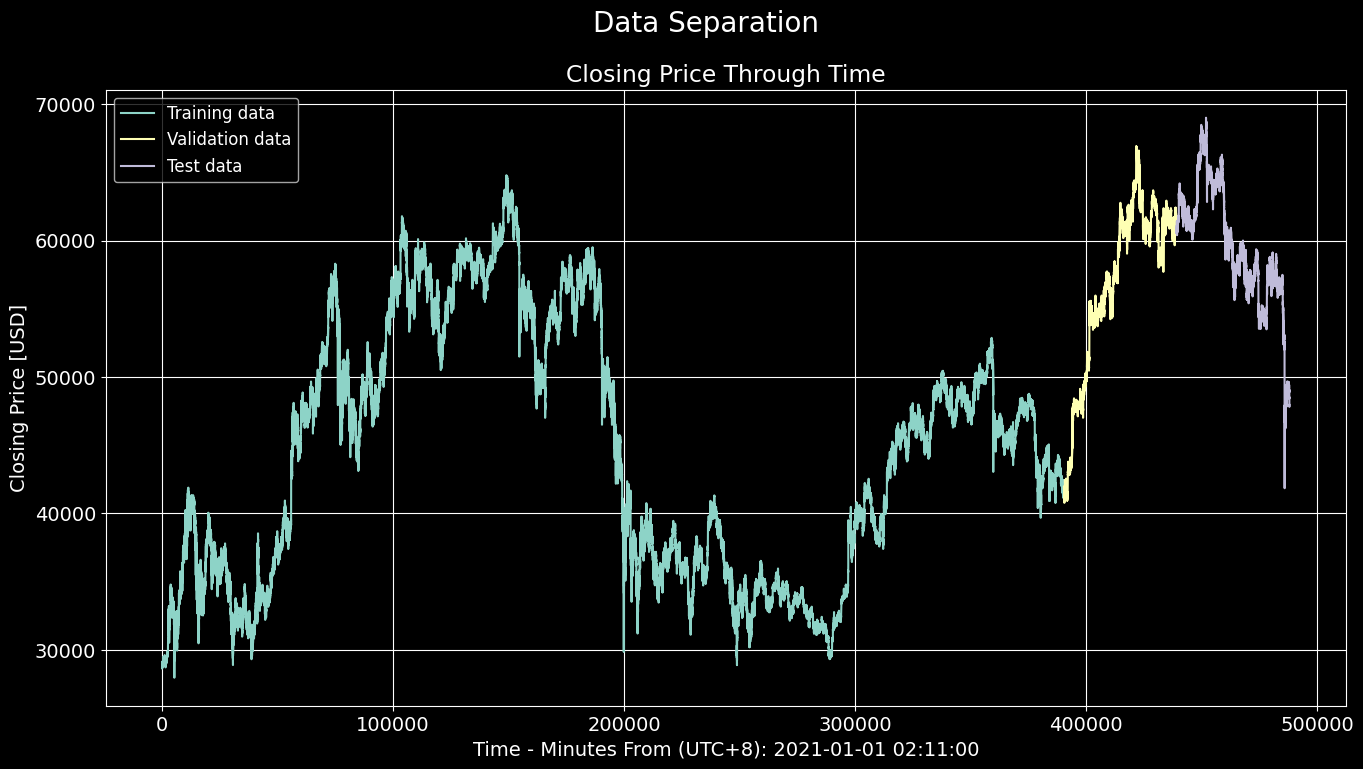

In [33]:
# plot train, validation and test separation
if plot_data_process:
    train_time = np.arange(np.size(train_df, 0))
    if val_df is not None:
        val_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(val_df, 0))
        test_time = np.arange(np.size(train_df, 0) + np.size(val_df, 0), np.size(train_df, 0) + np.size(val_df, 0) + np.size(test_df, 0))
    else:
        test_time = np.arange(np.size(train_df, 0), np.size(train_df, 0) + np.size(test_df, 0))
    fig = plt.figure(figsize=(16, 8))
    st = fig.suptitle("Data Separation", fontsize=20)
    ax = fig.add_subplot(1, 1 ,1)
    ax.set_xlabel("Time - Minutes From (UTC+8): 2021-01-01 {:02d}:{:02d}:00".format(start_hour, start_minute))     
    ax.set_ylabel("Closing Price [USD]")            
    ax.set_title("Closing Price Through Time")
    ax.plot(train_time, train_df['Closing_price'], label='Training data')
    if val_df is not None:
        ax.plot(val_time, val_df['Closing_price'], label='Validation data')
    ax.plot(test_time, test_df['Closing_price'], label='Test data')
    ax.grid()
    ax.legend(loc="best", fontsize=12) 
    plt.show()

In [34]:
# Hyper-Parameters interpretation
predicted_feature = train_df.columns.get_loc('Closing_price')
if scaler_name == 'standard':
    scaler = pp.StandardScaler()
if scaler_name == 'minmax':
    scaler = pp.MinMaxScaler()
in_features = num_features
criterion = nn.MSELoss()

# define the model
model = BTC_Transformer(num_encoder_layers=num_encoder_layers,
                        num_decoder_layers=num_decoder_layers,
                        in_features=in_features,
                        periodic_features=periodic_features,
                        out_features=out_features,
                        nhead=nhead,
                        dim_feedforward=dim_feedforward,
                        dropout=dropout,
                        activation=activation
                       ).to(device)

# optimization
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)

# create the relevant data
train = train_df.iloc[:, :num_features]
if val_df is not None:
    val = val_df.iloc[:, :num_features]
else:
    val = val_df
test = test_df.iloc[:, :num_features]
train, val ,test ,scaler = normalize_data(train, val ,test ,scaler)
train_data = betchify(train, train_batch_size).float()
if val is not None:
    val_data = betchify(val, eval_batch_size).float()
test_data = betchify(test, eval_batch_size).float()

c:\Users\23695\PycharmProjects\-Bitcoin-Price-Prediction-Using-Transformers\.venv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [35]:
# print the model
model_stats = summary(
                model = model, 
                input_data = [(bptt_src, in_features), (bptt_tgt, in_features)], 
                dtypes = [torch.float, torch.float],
                batch_dim = 1,
                col_names = ("input_size", "output_size", "num_params"),
                device = device, 
                depth = 4, 
                verbose = 0
                )
print(str(model_stats))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #
├─SineActivation: 1-1                              [10, -1, 34]              [10, -1, 60]              --
|    └─Dropout: 2-1                                [10, -1, 60]              [10, -1, 60]              --
├─SineActivation: 1-2                              [2, -1, 34]               [2, -1, 60]               (recursive)
|    └─Dropout: 2-2                                [2, -1, 60]               [2, -1, 60]               --
├─Transformer: 1-3                                 [10, -1, 60]              [2, -1, 60]               --
|    └─TransformerEncoder: 2-3                     [10, -1, 60]              [10, -1, 60]              --
|    |    └─ModuleList: 3                          []                        []                        --
|    |    |    └─TransformerEncoderLayer: 4-1      [10, -1, 60]              [10, -1, 60]              61,404
|    |    |    └─Transformer

In [ ]:
## train the model
# prepare vars to hold best model and training statistics
best_val_loss = float('inf')
best_model = None
train_loss = []
valid_loss = []

for epoch in range(1, epochs + 1):
    # epoch initialization
    epoch_start_time = time.time()
    model.train()
    total_loss = 0.
    epoch_loss = 0.
    start_time = time.time()
    
    # start point of the data
    if random_start_point:
        start_point = np.random.randint(bptt_src)
    else:
        start_point = 0
    
    num_batches = (len(train_data) - start_point) // bptt_src
    log_interval = round(num_batches // 3 / 10) * 10
    
    # masks for the model 
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device) # zeros mask for the source (no mask)
    tgt_mask = model.transformer.generate_square_subsequent_mask(bptt_tgt).to(device) # look-ahead mask for the target
    

    for batch, i in enumerate(range(start_point, train_data.size(0) - 1, bptt_src)):
        # forward
        source, targets = get_batch(train_data, i, bptt_src, bptt_tgt, overlap)
        src_batch_size = source.size(0)
        tgt_batch_size = targets.size(0)
        if tgt_batch_size != bptt_tgt or src_batch_size != bptt_src:  # only on last batch
            src_mask = src_mask[:src_batch_size, :src_batch_size]
            tgt_mask = tgt_mask[:tgt_batch_size, :tgt_batch_size]
        output = model(source, targets, src_mask, tgt_mask)
        loss = criterion(output[:-1,:,predicted_feature], targets[1:,:,predicted_feature])
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_param)
        
        # step
        optimizer.step()
        
        # record bacth statistics
        total_loss += loss.item()
        epoch_loss += len(source) * loss.item()

        # print statistics every log_interval
        if (batch % log_interval == 0) and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.6f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.6f} ')
            total_loss = 0
            start_time = time.time()
    
    # record epoch statistics
    train_loss.append(epoch_loss / (len(train_data) - 1))
    
    # evaluate on validation and save best model
    if val is not None:
        val_loss = evaluate(model, val_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
        elapsed = time.time() - epoch_start_time
        print('-' * 77)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
             f'valid loss {val_loss:5.6f} ')
        print('-' * 77)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            
        valid_loss.append(np.mean(val_loss))

    # scheduler step
    scheduler.step()
              
if val is None:
    best_model = copy.deepcopy(model)

| epoch   1 |   410/ 1220 batches | lr 0.500000 | ms/batch 19.17 | loss 0.242958 
| epoch   1 |   820/ 1220 batches | lr 0.500000 | ms/batch 18.72 | loss 0.005929 
-----------------------------------------------------------------------------
| end of epoch   1 | time: 23.69s | valid loss 0.009221 
-----------------------------------------------------------------------------
| epoch   2 |   410/ 1220 batches | lr 0.475000 | ms/batch 18.45 | loss 0.001358 
| epoch   2 |   820/ 1220 batches | lr 0.475000 | ms/batch 18.32 | loss 0.000843 
-----------------------------------------------------------------------------
| end of epoch   2 | time: 23.31s | valid loss 0.004452 
-----------------------------------------------------------------------------
| epoch   3 |   410/ 1220 batches | lr 0.451250 | ms/batch 18.48 | loss 0.000350 
| epoch   3 |   820/ 1220 batches | lr 0.451250 | ms/batch 18.45 | loss 0.000329 
-----------------------------------------------------------------------------
| en

In [ ]:
# plot loss functions
epochs_list = np.arange(1,epochs + 1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.set_title("Loss vs. Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.plot(epochs_list, train_loss, label='Training Loss')
if val is not None:
    ax.plot(epochs_list, valid_loss, label='Validation Loss')
ax.legend() 
plt.show()

In [ ]:
# calculate test loss
test_loss = evaluate(best_model, test_data, bptt_src, bptt_tgt, overlap, criterion, predicted_feature)
test_ppl = math.exp(test_loss)
print('-' * 77)
print(f'test loss {test_loss:5.6f}')
print('-' * 77)

In [38]:
def greedy_decode(model, src, bptt_src, pred_len, overlap):
    """use the model to create a pridection of pred_len out of src
    
    Args:
        model: nn.Module, the model you want to run the data in
        src: Tensor, shape [N, 1, E]
        bptt_src: int, size of back propagation through time, sequence length of source
        pred_len: int, desired prediction length
        overlap: int, number of overlapping elements between source and target
        
    Returns:
        greedy_output: tesnor, shape [pred_len, 1, E], holds the predictions based on src

    """
    model.eval()
    if overlap == 0:
        start_point = src[-1:, :, :]
        src = src[:-1, :, :]
    else:
        start_point = src[-overlap:,:,:]
    bptt_src = src.size(0)
    src_mask = torch.zeros((bptt_src,bptt_src), dtype=torch.bool).to(device)
    memory = model.encode(src, src_mask)
    targets = start_point
    for i in range(pred_len):
        tgt_mask = model.transformer.generate_square_subsequent_mask(targets.size(0)).to(device)
        prediction = model.decode(targets, memory, tgt_mask)
        prediction = model.generator(prediction)
        targets = torch.cat([start_point, prediction[:i+1]], dim=0)
        
    greedy_output = prediction[:pred_len,:,:]
    greedy_output = greedy_output.detach()
    return greedy_output

In [39]:
def estimate_BTC(best_model, test, num_features, bptt_src, bptt_tgt, overlap, predicted_feature, scaler, use_real=True, early_stop=1):
    """use the best model to create a pridection on the test up to early_stop percentage of it
    
    Args:
        model: nn.Module, the model you want to run the data in
        test: Tensor, shape [N, E]
        num_features: int, number of features used to train the model
        bptt_src: int, size of back propagation through time, sequence length of source
        bptt_tgt: int, size of back propagation through time, sequence length of target
        overlap: int, number of overlapping elements between source and target
        predicted_feature: int, index of the feature you want to evaluate in [0,E-1]
        scaler: function, scaler fitted to train set
        use_real: bool, when True use the real data for future predictions, when False use the previous prediction
        early_stop: float, percentage of test you want to predict (0,1]
        

    Returns:
        feature_unnormalized: ndarray, holds the real values of the chosen feature in the test in original scale
        feature_prediction_unnormalized: ndarray, holds the predicted values of the chosen feature starting from bptt_src in original scale
        inference_bptt_src: int, starting point of the predictions
    """
    inference_batch_size = 1
    inference_bptt_src = bptt_src + (overlap == 0)
    pred_len = min(bptt_tgt - overlap, bptt_tgt - 1)
    test_data = betchify(test[:, :num_features], inference_batch_size).float()
    num_iter = (test_data.size(0) - bptt_src) // pred_len
    inference_data = test_data[:inference_bptt_src, :, :]
    for i in range(num_iter):
        prediction = greedy_decode(best_model, inference_data, bptt_src, pred_len, overlap)
        if use_real:
            inference_data = test_data[i * pred_len: i * pred_len + inference_bptt_src, :, :]
        else:
            inference_data =  torch.cat([inference_data, prediction], dim=0)[pred_len:]
        if i == 0:
            predictions = prediction
        else:
            predictions = torch.cat([predictions, prediction], dim=0)
        if i > num_iter * early_stop:
            break
            
    feature_unnormalized = scaler.inverse_transform(torch.transpose(test_data, 0, 1).reshape(-1,num_features).cpu())[:,predicted_feature]
    feature_prediction_unnormalized = scaler.inverse_transform(torch.transpose(predictions, 0, 1).reshape(-1,num_features).cpu())[:,predicted_feature]
    
    return feature_unnormalized, feature_prediction_unnormalized, inference_bptt_src

In [40]:
# predict over the test set
early_stop = 1
feature_real, feature_prediction, pred_start = estimate_BTC(best_model, test, num_features, bptt_src, bptt_tgt,
                                                            overlap, predicted_feature, scaler, use_real=True, early_stop=early_stop)
real_time = np.arange(0, np.size(feature_real))
prediction_time = np.arange(pred_start, pred_start + np.size(feature_prediction))

In [ ]:
# plot predictions with real price
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1 ,1)
ax.set_xlabel("Time [Minutes]")     
ax.set_ylabel("Closing Price [USD]")  
ax.set_title("Closing price through time")   
ax.grid()
ax.plot(real_time, feature_real, label='Real Values')
ax.plot(prediction_time, feature_prediction, label='Predicted Values')
ax.set_xlim(0, np.size(prediction_time))
ax.set_ylim(min(min(feature_prediction), min(feature_real[:np.size(prediction_time)])), 
            max(max(feature_prediction), max(feature_real[:np.size(prediction_time)])))
ax.legend()    
plt.show()

In [ ]:
# plot predictions with real price - zoom in to point of interest
desired_range = [42550, 42650]
low = desired_range[0]
high = desired_range[1]
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1 ,1)
ax.set_xlabel("Time [Minutes]")     
ax.set_ylabel("Closing Price [USD]")  
ax.set_title("Closing price through time - Zoom In")   
ax.grid()
ax.plot(real_time, feature_real, label='Real Values')
ax.plot(prediction_time, feature_prediction, label='Predicted Values')
ax.set_xlim(low, high)
ax.set_ylim(min(min(feature_prediction[low:high]), min(feature_real[low:high])), 
            max(max(feature_prediction[low:high]), max(feature_real[low:high])))
ax.legend()
plt.show()